<Axes: xlabel='timestamp'>

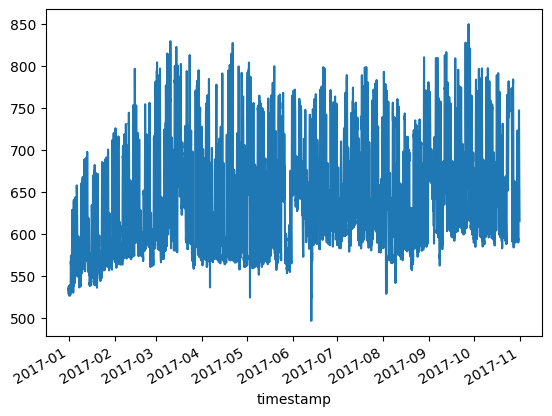

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

building_df = pd.read_csv("data/building_5_weather_1_train.csv", parse_dates=['timestamp'])
weather_df = pd.read_csv("data/weather_1.csv", parse_dates=['timestamp'])

building_df.drop_duplicates(inplace=True)
building_df.set_index('timestamp',inplace=True)
weather_df.drop_duplicates(inplace=True)
weather_df.set_index('timestamp',inplace=True)

data = building_df.join(weather_df,how='inner',on='timestamp')


data['power'].plot()

## Outliers

### Z-score Outlier

timestamp
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


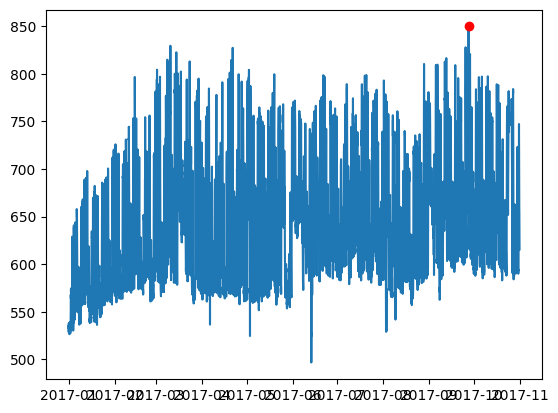

In [64]:
# calculate z-scores for each column
z_scores = (data['power'] - data['power'].mean()) / data['power'].std()

# define std limit (default 3)
std_limit = 3

# identify outliers as data points with z-score greater than std_limit or less than -std_limit
outliers = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(outliers)

# plot column 'a' with outlier in red
plt.plot(data['power'])
plt.plot(outliers.index, data.loc[outliers.index, 'power'], 'ro')
plt.show()

outliers_z_score = outliers



### Boxplot interquantile

timestamp
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


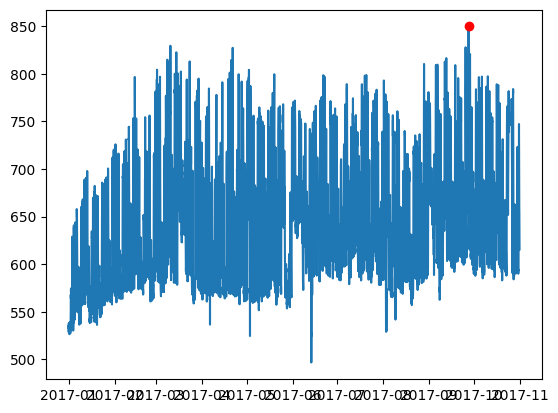

In [65]:
# evaluate 1st quartile
Q1 = data['power'].quantile(0.25)

# evalutate 3rd quartile
Q3 = data['power'].quantile(0.75)

# evaluate interquartile
IQR = Q3 - Q1

# define IQR limit (default 1.5)
IQR_limit = 1.5

# identify and highlight outliers
outliers = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(outliers)

plt.plot(data['power'])
plt.plot(outliers.index, data.loc[outliers.index, 'power'], 'ro')
plt.show()

outliers_interquantile = outliers

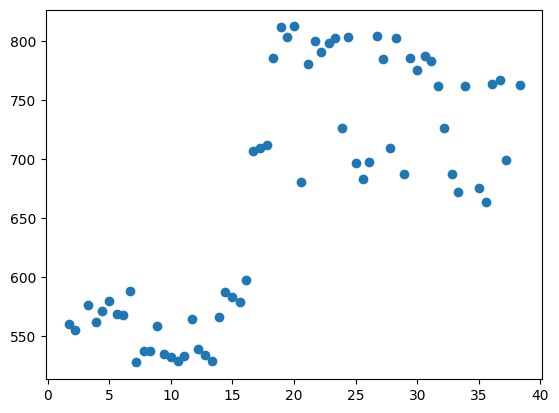

In [55]:
plt.scatter(data['airTemperature'],data['power'])
plt.scatter(data['airTemperature'].loc[outliers_interquantile.index],outliers_interquantile,c='red')
plt.scatter(data['airTemperature'].loc[outliers_z_score.index],outliers_z_score,c='green')
plt.show()

### Remove outliers

In [56]:
data.power.loc[outliers_z_score.index] = np.nan

data.head()

,power,airTemperature
timestamp,,
2017-01-01 00:00:00,537.1756,8.3
2017-01-01 01:00:00,528.6003,10.6
2017-01-01 02:00:00,532.4253,11.1
2017-01-01 03:00:00,535.8997,NaN
2017-01-01 04:00:00,531.9250,NaN


## NA

In [57]:
print(data['power'].isna().sum())
print(data['airTemperature'].isna().sum())

2
6980


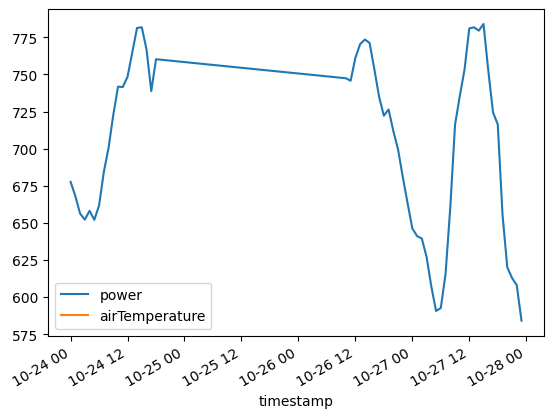

In [58]:
data[data['power'].isna()]

data["2017-10-24":"2017-10-27"].plot()

data['power'].interpolate('spline',limit=3,inplace=True,order=3)

data.dropna(subset=['power'],inplace=True)

#data[data['power'].isna()]

## Data visualization

##  Load profiles characterization

In [59]:
data.index.duplicated().sum()

data['hour'] = data.index.hour
#data['date'] = data.index.map(lambda t:t.strftime('%Y-%m-%d'))
data['date'] = data.index.date

pv_data = data.pivot(index='date',columns='hour',values='power')

### K-Means

In [61]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_range = [i for i in range(2,8)]
db_list = []
sh_list = []

for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=0).fit(pv_data)
  db_list.append(silhouette_score(pv_data,kmeans.labels))
  sh_list.append(davies_bouldin_score(pv_data,kmeans.labels))

print(f"The best number of clusters according to Silhouette is {k_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {k_range[np.argmin(db_list)]}")

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values